In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import os
import uuid
import shutil
from glob import glob
from datetime import date
import functools

%tensorflow_version 1.x
import tensorflow as tf
tf.version

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from tqdm import tqdm, trange
!pip install sacred
import sacred
from sacred.stflow import LogFileWriter

import seaborn as sns
import matplotlib.pyplot as plt

# from somvae_model import SOMVAE
from utils import *

TensorFlow 1.x selected.
     |████████████████████████████████| 92kB 10.7MB/s 
     |████████████████████████████████| 102kB 13.0MB/s 
     |████████████████████████████████| 163kB 51.4MB/s 
     |████████████████████████████████| 71kB 10.2MB/s 
  Created wheel for sacred: filename=sacred-0.8.1-py2.py3-none-any.whl size=105019 sha256=e1eb875870e77c8a0df1cb04bbd2c62cfe65486c9aab730248f6849ca891925b
  Stored in directory: /root/.cache/pip/wheels/11/a8/f6/1d5f073245cb0a221962713adf81e56c1c9608083f85ecac9b
  Created wheel for py-cpuinfo: filename=py_cpuinfo-7.0.0-cp36-none-any.whl size=20071 sha256=29e21a937a94ff2e993fba892d76d47808a2ef60e845ee7a8274f5eb497b1a6d
  Stored in directory: /root/.cache/pip/wheels/f1/93/7b/127daf0c3a5a49feb2fecd468d508067c733fba5192f726ad1
Successfully built sacred py-cpuinfo


In [ ]:
tf.version

<module 'tensorflow._api.v1.version' from '/tensorflow-1.15.2/python3.6/tensorflow_core/_api/v1/version/__init__.py'>

# Get time series

In [ ]:
import get_time_series 

In [ ]:
year_data = 'Twitter15'
dest = 'tw15'

t = os.path.join('gdrive/My Drive/Master/Data', year_data, 'tree.tar.gz')
p = os.path.join('gdrive/My Drive/Master/Data', year_data, 'post.tar.gz')
u = os.path.join('gdrive/My Drive/Master/Data', year_data, 'users.tar.gz')
l = os.path.join('gdrive/My Drive/Master/Data', year_data, 'label.txt')

!mkdir "$dest"
!tar -xzvf "$t" -C "$dest"
!tar -xzvf "$p" -C "$dest"
!tar -xzvf "$u" -C "$dest"
!cp "$l" "$dest"

In [ ]:
class data_process:
    def __init__(self, path = './'):
        self.news = get_time_series.load_data(path = path)
        self.posts = get_time_series.load_data_posts(path = path)
        self.users = get_time_series.load_data_users(path = path)

In [ ]:
def ts_div_time_interactions(news, time, window, sliding_window):
    nodes_order = news.tree.nodes_order
    freq_ret, freq_rep, tic = ([] for i in range(3))
    if sliding_window:
        step = 1            #avanza de a un minuto, overlap
    else: 
        step = window       #avanza en una ventana de tiempo, disjuntos
    for i in np.arange(news.tree.first_time, news.tree.first_time + time, step): # interval lim inf 
            f_ret = 0
            f_rep = 0
            j = 0
            while j<len(nodes_order):
                if round(i,2) <= nodes_order[j].timestamp and nodes_order[j].timestamp <= round(i+window,2):
                    if nodes_order[j].retweet:
                        f_ret += 1       
                    else:
                        f_rep += 1
                j +=1      
            freq_ret.append(f_ret)
            freq_rep.append(f_rep)
            tic.append(i)
            
    return np.array(tic), np.array(freq_ret), np.array(freq_rep)

def get_interactions(news_dict, window, sliding_window, time):
    label_to_idx = {'true': 0, 'non-rumor': 1, 'unverified': 2, 'false': 3}
    retweets, posts, labels = ([] for i in range(3))
    for id_ in news_dict.keys():
        x, y_ret, y_rep = ts_div_time_interactions(news_dict[id_], time, window, sliding_window)
        labels.append(label_to_idx[news_dict[id_].label]) 
        retweets.append(y_ret)
        posts.append(y_rep)
    
    return np.array(labels), np.array(retweets), np.array(posts)

In [ ]:
data = data_process('tw15')

In [ ]:
labels, retweets, posts = get_interactions(data.news, 10, True, 720)
interactions = retweets + posts
# grad_interactions_1 = np.gradient(interactions, axis=1)
# grad_interactions_2 = np.gradient(grad_interactions_1, axis=1)    

In [ ]:
window = 10
slide_window = True
time = 720
print('new users')
labels, new_users = get_time_series.get_fingerprints(data.news, data.users, data.posts, 'new_users', window, slide_window, time)
print('followers')
labels, followers = get_time_series.get_fingerprints(data.news, data.users, data.posts, 'followers', window, slide_window, time)
print('followings')
labels, followings = get_time_series.get_fingerprints(data.news, data.users, data.posts, 'followings', window, slide_window, time)

new users
followers
followings


In [ ]:
print(labels.shape)
print(new_users.shape)
print(followers.shape)
print(followings.shape)

(1490,)
(1490, 720)
(1490, 720)
(1490, 720)


In [ ]:
print(labels.shape)
print(retweets.shape)
print(posts.shape)
print(interactions.shape)
# print(grad_interactions_1.shape)
# print(grad_interactions_2.shape)

(1490,)
(1490, 720)
(1490, 720)
(1490, 720)


In [ ]:
def get_multivariate_series(time_series, labels, scale = 1): 
        paa = PiecewiseAggregateApproximation(n_segments=140) # equals the number of segments and samples!!!
        digits = []
        for i in range(72):
            digits.append(i*10)
        digits = np.array(digits)
        
        if scale == 0:
            time_series_scaled = []
            for ts in time_series:
                scaler = MinMaxScaler()
                # scaler = StandardScaler()
                scaler.fit(ts)
                ts = scaler.transform(ts)
                ts = ts.reshape(ts.shape[0],ts.shape[1])
                time_series_scaled.append(ts)
        elif scale == 1:
            time_series_scaled = []
            for ts in time_series:
                scaler = MinMaxScaler()
                scaler.fit(ts)
                ts = scaler.transform(ts)
                # print('1 ', ts.shape)
                ts = ts.reshape(ts.shape[0], ts.shape[1], 1)
                ts = paa.inverse_transform(paa.fit_transform(ts))
                # print(ts.shape)
                ts = ts[:,digits,:]
                # print(ts.shape)
                ts = ts.reshape(ts.shape[0],ts.shape[1])
                # print(ts.shape)
                time_series_scaled.append(ts)                
        time_series_multi = np.stack(time_series_scaled, axis=-1) # -1
        return time_series_multi

In [ ]:
!pip install tslearn
from tslearn.piecewise import PiecewiseAggregateApproximation

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
time_series = get_multivariate_series(time_series=[posts, retweets, interactions, new_users, followers, followings], labels=labels, scale=1) #posts, retweets, 
x_train, x_test, y_train, y_test = train_test_split(time_series, labels, test_size=0.2, stratify=labels)

In [ ]:
print(time_series.shape)
print(labels.shape)

(1490, 72, 6)
(1490,)


In [ ]:
!pip install tsaug

In [ ]:
from tsaug import AddNoise, Pool

my_augmenter = (AddNoise(scale=0.01) + 
                Pool(size=1) + 
                AddNoise(scale=0.02) + 
                Pool(size=2) * 5) 

X_aug = my_augmenter.augment(time_series)
Y_aug = np.array([[i]*5 for i in labels]).flatten()
print(X_aug.shape)
print(Y_aug.shape)
x_train, x_test, y_train, y_test = train_test_split(X_aug, Y_aug, test_size=0.2, stratify=Y_aug)

(4090, 720, 6)
(4090,)


In [ ]:
Y_aug[:20]

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0])

In [ ]:
print(time_series.shape)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1490, 72, 6)
(1192, 72, 6)
(1192,)
(298, 72, 6)
(298,)


In [ ]:
data_train = np.expand_dims(x_train, axis=3) #x_train
data_val = np.expand_dims(x_test, axis=3) #x_test

labels_val = y_test
labels_train = y_train

In [ ]:
print(data_train.shape)
print(labels_train.shape)
print(data_val.shape)
print(labels_val.shape)

(1192, 72, 6, 1)
(1192,)
(298, 72, 6, 1)
(298,)


# SOM-VAE Clustering

In [ ]:
def weight_variable(shape, name):
    """Creates a TensorFlow Variable with a given shape and name and truncated normal initialization."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial,name=name)

def bias_variable(shape, name):
    """Creates a TensorFlow Variable with a given shape and name and constant initialization."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

def conv2d(x, shape, name, strides=[1,1,1,1]):
    """Creates a 2D convolutional layer with weight and bias variables.
    Args:
        x (tf.Tensor): Input tensor.
        shape (list): Shape of the weight matrix.
        name (str): Name of the layer.
        strides (list): Strides for the convolution (default: [1,1,1,1]).
    Returns:
        tf.Tensor: The convolution defined by the weight matrix and the biases with the given strides.
    """
    weight = weight_variable(shape, "{}_W".format(name))
    bias = bias_variable([shape[-1]], "{}_b".format(name))
    return tf.nn.conv2d(x, weight, strides=strides, padding='SAME', name=name) + bias

def conv2d_transposed(x, shape, outshape, name, strides=[1,1,1,1]):
    """Creates a transposed convolutional layer simimar to conv2d.
    Args:
        x (tf.Tensor): Input tensor.
        shape (list): Shape of the weight matrix.
        name (str): Name of the layer.
        strides (list): Strides for the convolution (default: [1,1,1,1]).
    Returns:
        tf.Tensor: The transposed convolution defined by the weight matrix and the biases with the given strides.
    """
    weight = weight_variable(shape, "{}_W".format(name))
    bias = bias_variable([shape[-2]], "{}_b".format(name))
    return tf.nn.conv2d_transpose(x, weight, output_shape=outshape, strides=strides, padding='SAME', name=name) + bias

def max_pool_2x2(x):
    """Creates a 2x2 max-pooling layer."""
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def conv1d(x, shape, name, stride=1):
    """Creates a 1D convolutional layer with weight and bias variables.
    Args:
        x (tf.Tensor): Input tensor.
        shape (list): Shape of the weight matrix.
        name (str): Name of the layer.
        stride (int): Stride for the convolution (default: 1).
    Returns:
        tf.Tensor: The convolution defined by the weight matrix and the biases with the given stride.
    """
    weight = weight_variable(shape, "{}_W".format(name))
    bias = bias_variable([shape[-1]], "{}_b".format(name))
    return tf.nn.conv1d(x, weight, stride=stride, padding='SAME', name=name) + bias

def max_pool_2x1(x):
    """Creates a 2x1 max-pooling layer."""
    return tf.layers.max_pooling1d(x, pool_size=2, strides=2, padding='SAME')

def lazy_scope(function):
    """Creates a decorator for methods that makes their return values load lazily.
    A method with this decorator will only compute the return value once when called
    for the first time. Afterwards, the value will be cached as an object attribute.
    Inspired by: https://danijar.com/structuring-your-tensorflow-models
    Args:
        function (func): Function to be decorated. 
    Returns:
        decorator: Decorator for the function.
    """
    attribute = "_cache_" + function.__name__

    @property
    @functools.wraps(function)
    def decorator(self):
        if not hasattr(self, attribute):
            with tf.variable_scope(function.__name__):
                setattr(self, attribute, function(self))
        return getattr(self, attribute)
    return decorator

class SOMVAE:
    """Class for the SOM-VAE model as described in https://arxiv.org/abs/1806.02199"""

    def __init__(self, inputs, latent_dim=64, som_dim=[8,8], learning_rate=1e-4, decay_factor=0.95, decay_steps=1000,
            input_length=28, input_channels=28, alpha=1., beta=1., gamma=1., tau=1., mnist=True):
        """Initialization method for the SOM-VAE model object.
        Args:
            inputs (tf.Tensor): The input tensor for the model.
            latent_dim (int): The dimensionality of the latent embeddings (default: 64).
            som_dim (list): The dimensionality of the self-organizing map (default: [8,8]).
            learning_rate (float): The learning rate for the optimization (default: 1e-4).
            decay_factor (float): The factor for the learning rate decay (default: 0.95).
            decay_steps (int): The number of optimization steps before every learning rate
                decay (default: 1000).
            input_length (int): The length of the input data points (default: 28).
            input_channels (int): The number of channels of the input data points (default: 28).
            alpha (float): The weight for the commitment loss (default: 1.).
            beta (float): The weight for the SOM loss (default: 1.).
            gamma (float): The weight for the transition probability loss (default: 1.).
            tau (float): The weight for the smoothness loss (default: 1.).
            mnist (bool): Flag that tells the model if we are training in MNIST-like data (default: True).
        """
        self.latent_dim = latent_dim
        self.som_dim = som_dim
        self.learning_rate = learning_rate
        self.decay_factor = decay_factor
        self.decay_steps = decay_steps
        self.input_length = input_length
        self.input_channels = input_channels
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.tau = tau
        self.mnist = mnist
        self.inputs = inputs
        self.is_training  
        self.batch_size
        self.embeddings
        self.transition_probabilities
        self.global_step
        self.z_e
        self.z_e_old
        self.z_dist_flat
        self.k
        self.z_q
        self.z_q_neighbors
        self.reconstruction_q
        self.reconstruction_e
        self.loss_reconstruction
        self.loss_commit
        self.loss_som
        self.loss_probabilities
        self.loss_z_prob
        self.loss
        self.optimize

    @lazy_scope
    def is_training(self):
        is_training = tf.placeholder(tf.bool, shape=[], name="is_training")
        return is_training

    @lazy_scope
    def embeddings(self):
        """Creates variable for the SOM embeddings."""
        embeddings = tf.get_variable("embeddings", self.som_dim+[self.latent_dim],
                             initializer=tf.truncated_normal_initializer(stddev=0.05))
        tf.summary.tensor_summary("embeddings", embeddings)
        return embeddings #SOM map with shape som_dim[0], som_dim[1], latent_dim

    @lazy_scope
    def transition_probabilities(self):
        """Creates tensor for the transition probabilities."""
        with tf.variable_scope("probabilities"):
            probabilities_raw = tf.Variable(tf.zeros(self.som_dim+self.som_dim), name="probabilities_raw")
            probabilities_positive = tf.exp(probabilities_raw)
            probabilities_summed = tf.reduce_sum(probabilities_positive, axis=[-1,-2], keepdims=True)
            probabilities_normalized = probabilities_positive / probabilities_summed
            return probabilities_normalized

    @lazy_scope
    def global_step(self):
        """Creates global_step variable for the optimization."""
        global_step = tf.Variable(0, trainable=False, name="global_step")
        return global_step

    @lazy_scope
    def batch_size(self):
        """Reads the batch size from the input tensor."""
        batch_size = tf.shape(self.inputs)[0]
        return batch_size

    @lazy_scope
    def z_e(self):
        """Computes the latent encodings of the inputs."""
        if not self.mnist:
            with tf.variable_scope("encoder"):
                # print('inputs ', self.inputs)
                # h_1 = tf.keras.layers.Dense(32, activation="relu")(self.inputs)
                # h_2 = tf.keras.layers.Dense(16, activation="relu")(h_1)
                # h_3 = tf.keras.layers.Flatten()(h_2)
                # z_e = tf.keras.layers.Dense(self.latent_dim, activation="relu")(h_3)#(h_2)
                # print('z_e', z_e)
                # h_conv1 = tf.nn.relu(conv1d(self.inputs, [], "conv1"))
                # h_conv1 = tf.nn.relu(tf.nn.conv1d(input = self.inputs, filters = 8.0, stride=3, padding="VALID"))

                h_conv1 = tf.nn.relu(tf.keras.layers.Conv2D(8,3)(self.inputs)) #8,3
                h_pool1 = tf.keras.layers.Dropout(0.1)(h_conv1) #tf.nn.dropout(h_conv1, 0.9)# 0.1)
                print(h_pool1)
                h_conv2 = tf.nn.relu(tf.keras.layers.Conv2D(8,3)(h_pool1))  #8,3
                h_pool2 = tf.keras.layers.Dropout(0.1)(h_conv2)
                print(h_pool2)
                # flat_size = 716*8
                # h_flat = tf.reshape(h_pool2, [-1, flat_size])
                h_flat = tf.keras.layers.Flatten()(h_pool2)
                z_e = tf.keras.layers.Dense(self.latent_dim)(h_flat)
                print('fin z_e', z_e)

                #dense try
                # x = tf.keras.layers.Flatten()(self.inputs)
                # x = tf.keras.layers.Dense(16, activation='relu')(x)
                # x = tf.keras.layers.Dropout(0.1)(x)
                # x = tf.keras.layers.Dense(8, activation='relu')(x)
                # z_e = x
        else:
            with tf.variable_scope("encoder"):
                h_conv1 = tf.nn.relu(conv2d(self.inputs, [4,4,1,256], "conv1"))
                h_pool1 = max_pool_2x2(h_conv1)
                h_conv2 = tf.nn.relu(conv2d(h_pool1, [4,4,256,256], "conv2"))
                h_pool2 = max_pool_2x2(h_conv2)
                flat_size = 7*7*256
                h_flat = tf.reshape(h_pool2, [-1, flat_size])
                z_e = tf.keras.layers.Dense(self.latent_dim)(h_flat)
        return z_e

    @lazy_scope
    def z_e_old(self): #no se usa
        """Aggregates the encodings of the respective previous time steps."""
        z_e_old = tf.concat([self.z_e[0:1], self.z_e[:-1]], axis=0)
        return z_e_old

    @lazy_scope
    def z_dist_flat(self):
        """Computes the distances between the encodings and the embeddings."""
        z_dist = tf.squared_difference(tf.expand_dims(tf.expand_dims(self.z_e, 1), 1), tf.expand_dims(self.embeddings, 0))
        z_dist_red = tf.reduce_sum(z_dist, axis=-1)
        z_dist_flat = tf.reshape(z_dist_red, [self.batch_size, -1])
        return z_dist_flat

    @lazy_scope
    def k(self):
        """Picks the index of the closest embedding for every encoding."""
        k = tf.argmin(self.z_dist_flat, axis=-1, name="k")
        tf.summary.histogram("clusters", k)
        return k

    @lazy_scope
    def z_q(self):
        """Aggregates the respective closest embedding for every encoding."""
        k_1 = self.k // self.som_dim[1]
        k_2 = self.k % self.som_dim[1]
        k_stacked = tf.stack([k_1, k_2], axis=1)
        z_q = tf.gather_nd(self.embeddings, k_stacked, name="z_q") #de los embeddings agarra los indices k_stacked
        return z_q

    @lazy_scope
    def z_q_neighbors(self):
        """Aggregates the respective neighbors in the SOM for every embedding in z_q."""
        k_1 = self.k // self.som_dim[1]
        k_2 = self.k % self.som_dim[1]
        k_stacked = tf.stack([k_1, k_2], axis=1)

        k1_not_top = tf.less(k_1, tf.constant(self.som_dim[0]-1, dtype=tf.int64))
        k1_not_bottom = tf.greater(k_1, tf.constant(0, dtype=tf.int64))
        k2_not_right = tf.less(k_2, tf.constant(self.som_dim[1]-1, dtype=tf.int64))
        k2_not_left = tf.greater(k_2, tf.constant(0, dtype=tf.int64))

        k1_up = tf.where(k1_not_top, tf.add(k_1, 1), k_1)
        k1_down = tf.where(k1_not_bottom, tf.subtract(k_1, 1), k_1)
        k2_right = tf.where(k2_not_right, tf.add(k_2, 1), k_2)
        k2_left = tf.where(k2_not_left, tf.subtract(k_2, 1), k_2)

        z_q_up = tf.where(k1_not_top, tf.gather_nd(self.embeddings, tf.stack([k1_up, k_2], axis=1)),
                          tf.zeros([self.batch_size, self.latent_dim]))
        z_q_down = tf.where(k1_not_bottom, tf.gather_nd(self.embeddings, tf.stack([k1_down, k_2], axis=1)),
                          tf.zeros([self.batch_size, self.latent_dim]))
        z_q_right = tf.where(k2_not_right, tf.gather_nd(self.embeddings, tf.stack([k_1, k2_right], axis=1)),
                          tf.zeros([self.batch_size, self.latent_dim]))
        z_q_left = tf.where(k2_not_left, tf.gather_nd(self.embeddings, tf.stack([k_1, k2_left], axis=1)),
                          tf.zeros([self.batch_size, self.latent_dim]))

        z_q_neighbors = tf.stack([self.z_q, z_q_up, z_q_down, z_q_right, z_q_left], axis=1)
        return z_q_neighbors

    @lazy_scope
    def reconstruction_q(self):
        """Reconstructs the input from the embeddings."""
        with tf.variable_scope("decoder", reuse=tf.AUTO_REUSE):
            z_p = tf.placeholder(tf.float32, shape=[None, self.latent_dim], name="z_q")
            z_q = tf.cond(self.is_training, lambda: self.z_q, lambda: z_p)
            if not self.mnist:
                # h_3 = tf.keras.layers.Dense(128, activation="relu")(z_q)
                # h_4 = tf.keras.layers.Dense(256, activation="relu")(h_3)
                # x_hat = tf.keras.layers.Dense(self.input_channels, activation="sigmoid")(h_4)

                # h_conv1 = tf.nn.relu(tf.keras.layers.Conv1D(8,3)(self.inputs))
                # h_pool1 = tf.keras.layers.Dropout(0.1)(h_conv1) #tf.nn.dropout(h_conv1, 0.9)# 0.1)
                # print(h_pool1)
                # h_conv2 = tf.nn.relu(tf.keras.layers.Conv1D(8,3)(h_pool1))
                # h_pool2 = tf.keras.layers.Dropout(0.1)(h_conv2)
                # print(h_pool2)
                # flat_size = 716*8
                # h_flat = tf.reshape(h_pool2, [-1, flat_size])
                # # h_flat = tf.keras.layers.Flatten()(h_pool2)
                # z_e = tf.keras.layers.Dense(self.latent_dim)(h_flat)

                # flat_size = 32*8*2
                flat_size = 68*8*2
                # flat_size = 716*8*2
                print('init rec q ', z_q)
                h_flat_dec = tf.keras.layers.Dense(flat_size)(z_q)
                # h_reshaped = tf.reshape(h_flat_dec, [-1, 32, 2, 8])
                h_reshaped = tf.reshape(h_flat_dec, [-1, 68, 2, 8]) #[-1, 68, 2, 8]
                # h_reshaped = tf.reshape(h_flat_dec, [-1, 716, 2, 8])
                print(h_reshaped)
                h_deconv1 = tf.keras.layers.Conv2DTranspose(8,3)(h_reshaped)  #8,3
                print(h_deconv1)
                h_deconv2 = tf.keras.layers.Conv2DTranspose(1,3)(h_deconv1)  #1,3
                # print('output rec q ', h_deconv2)
                # h_unpool1 = tf.keras.layers.UpSampling2D((2,2))(h_reshaped)
                # h_deconv1 = tf.nn.relu(tf.nn.conv1d(h_reshaped, [ 718,8], "deconv1"))
                # h_unpool2 = tf.keras.layers.UpSampling2D((2,2))(h_deconv1)
                # h_deconv2 = tf.nn.sigmoid(conv1d(h_deconv1, [720, 5], "deconv2"))
                x_hat = h_deconv2
                print(x_hat)

                #dense try
                # x = tf.keras.layers.Dense(8, activation='relu')(z_q)
                # # x = tf.keras.layers.Dropout(0.1)(x)
                # x = tf.keras.layers.Dense(16, activation='relu')(x)
                # x = tf.reshape(x, [-1, 720, 5])
                # x_hat = x
            else:
                flat_size = 7*7*256
                h_flat_dec = tf.keras.layers.Dense(flat_size)(z_q)
                h_reshaped = tf.reshape(h_flat_dec, [-1, 7, 7, 256])
                h_unpool1 = tf.keras.layers.UpSampling2D((2,2))(h_reshaped)
                h_deconv1 = tf.nn.relu(conv2d(h_unpool1, [4,4,256,256], "deconv1"))
                h_unpool2 = tf.keras.layers.UpSampling2D((2,2))(h_deconv1)
                h_deconv2 = tf.nn.sigmoid(conv2d(h_unpool2, [4,4,256,1], "deconv2"))
                x_hat = h_deconv2
        return x_hat

    @lazy_scope
    def reconstruction_e(self):
        """Reconstructs the input from the encodings."""
        with tf.variable_scope("decoder", reuse=tf.AUTO_REUSE):
            # z_p = tf.placeholder(tf.float32, shape=[None, self.latent_dim], name="z_e")
            # z_e = tf.cond(self.is_training, lambda: self.z_e, lambda: z_p)
            if not self.mnist:
                # h_3 = tf.keras.layers.Dense(128, activation="relu")(self.z_e)
                # h_4 = tf.keras.layers.Dense(256, activation="relu")(h_3)
                # x_hat = tf.keras.layers.Dense(self.input_channels, activation="sigmoid")(h_4)

                # print('on reconstruction e', self.z_e)
                # flat_size = 32*8*2
                flat_size = 68*8*2
                # flat_size = 716*8*2
                print('init rec e ', self.z_e)
                h_flat_dec = tf.keras.layers.Dense(flat_size)(self.z_e)
                # h_reshaped = tf.reshape(h_flat_dec, [-1, 32, 2, 8])
                h_reshaped = tf.reshape(h_flat_dec, [-1, 68, 2, 8]) #[-1, 68, 2, 8]
                # h_reshaped = tf.reshape(h_flat_dec, [-1, 716, 2, 8])
                print(h_reshaped)
                h_deconv1 = tf.keras.layers.Conv2DTranspose(8,3)(h_reshaped)   #8,3
                print(h_deconv1)
                h_deconv2 = tf.keras.layers.Conv2DTranspose(1,3)(h_deconv1)   #1,3
                # print('output rec e ', h_deconv2)
                # h_unpool1 = tf.keras.layers.UpSampling2D((2,2))(h_reshaped)
                # h_deconv1 = tf.nn.relu(tf.nn.conv1d(h_reshaped, [ 718,8], "deconv1"))
                # h_unpool2 = tf.keras.layers.UpSampling2D((2,2))(h_deconv1)
                # h_deconv2 = tf.nn.sigmoid(conv1d(h_deconv1, [720, 5], "deconv2"))
                x_hat = h_deconv2
                print(x_hat)

                # #dense try
                # x = tf.keras.layers.Dense(8, activation='relu')(self.z_e)
                # # x = tf.keras.layers.Dropout(0.1)(x)
                # x = tf.keras.layers.Dense(16, activation='relu')(x)
                # print('x ', x)
                # x = tf.reshape(x, [-1, 720, 5])
                # x_hat = x
            else:
                flat_size = 7*7*256
                h_flat_dec = tf.keras.layers.Dense(flat_size)(self.z_e)
                h_reshaped = tf.reshape(h_flat_dec, [-1, 7, 7, 256])
                h_unpool1 = tf.keras.layers.UpSampling2D((2,2))(h_reshaped)
                h_deconv1 = tf.nn.relu(conv2d(h_unpool1, [4,4,256,256], "deconv1"))
                h_unpool2 = tf.keras.layers.UpSampling2D((2,2))(h_deconv1)
                h_deconv2 = tf.nn.sigmoid(conv2d(h_unpool2, [4,4,256,1], "deconv2"))
                x_hat = h_deconv2
        return x_hat

    @lazy_scope
    def loss_reconstruction(self):
        """Computes the combined reconstruction loss for both reconstructions."""
        print('inputs ', self.inputs)
        print('rec q ', self.reconstruction_q)
        loss_rec_mse_zq = tf.losses.mean_squared_error(self.inputs, self.reconstruction_q)
        print('loss rec zq', loss_rec_mse_zq)
        print('rec e ', self.reconstruction_e)
        loss_rec_mse_ze = tf.losses.mean_squared_error(self.inputs, self.reconstruction_e)
        print('loss rec ze', loss_rec_mse_ze)
        loss_rec_mse = loss_rec_mse_zq + loss_rec_mse_ze
        print('loss rec ', loss_rec_mse)
        tf.summary.scalar("loss_reconstruction", loss_rec_mse)
        return loss_rec_mse

    @lazy_scope
    def loss_commit(self):
        """Computes the commitment loss."""
        loss_commit = tf.reduce_mean(tf.squared_difference(self.z_e, self.z_q))
        tf.summary.scalar("loss_commit", loss_commit)
        return loss_commit

    @lazy_scope
    def loss_som(self):
        """Computes the SOM loss."""
        loss_som = tf.reduce_mean(tf.squared_difference(tf.expand_dims(tf.stop_gradient(self.z_e), axis=1), self.z_q_neighbors))
        tf.summary.scalar("loss_som", loss_som)
        return loss_som

    @lazy_scope
    def loss_probabilities(self):
        """Computes the negative log likelihood loss for the transition probabilities."""
        k_1 = self.k // self.som_dim[1]
        k_2 = self.k % self.som_dim[1]
        k_1_old = tf.concat([k_1[0:1], k_1[:-1]], axis=0)
        k_2_old = tf.concat([k_2[0:1], k_2[:-1]], axis=0)
        k_stacked = tf.stack([k_1_old, k_2_old, k_1, k_2], axis=1)
        transitions_all = tf.gather_nd(self.transition_probabilities, k_stacked)
        loss_probabilities = -self.gamma * tf.reduce_mean(tf.log(transitions_all))
        return loss_probabilities

    @lazy_scope
    def loss_z_prob(self):
        """Computes the smoothness loss for the transitions given their probabilities."""
        k_1 = self.k // self.som_dim[1]
        k_2 = self.k % self.som_dim[1]
        k_1_old = tf.concat([k_1[0:1], k_1[:-1]], axis=0)
        k_2_old = tf.concat([k_2[0:1], k_2[:-1]], axis=0)
        k_stacked_old = tf.stack([k_1_old, k_2_old], axis=1)
        out_probabilities_old = tf.gather_nd(self.transition_probabilities, k_stacked_old)
        out_probabilities_flat = tf.reshape(out_probabilities_old, [self.batch_size, -1])
        weighted_z_dist_prob = tf.multiply(self.z_dist_flat, out_probabilities_flat)
        loss_z_prob = tf.reduce_mean(weighted_z_dist_prob)
        return loss_z_prob

    @lazy_scope
    def loss(self):
        """Aggregates the loss terms into the total loss."""
        loss = (self.loss_reconstruction + self.alpha*self.loss_commit + self.beta*self.loss_som
                + self.gamma*self.loss_probabilities + self.tau*self.loss_z_prob)
        tf.summary.scalar("loss", loss)
        return loss

    @lazy_scope
    def optimize(self):
        """Optimizes the model's loss using Adam with exponential learning rate decay."""
        lr_decay = tf.train.exponential_decay(self.learning_rate, self.global_step, self.decay_steps, self.decay_factor, staircase=True)
        optimizer = tf.train.AdamOptimizer(lr_decay)
        train_step = optimizer.minimize(self.loss, global_step=self.global_step)
        train_step_prob = optimizer.minimize(self.loss_probabilities, global_step=self.global_step)
        return train_step, train_step_prob

In [ ]:
ex = sacred.Experiment("hyperopt", interactive=True)
ex.observers.append(sacred.observers.FileStorageObserver.create("sacred_runs"))
ex.captured_out_filter = sacred.utils.apply_backspaces_and_linefeeds

@ex.config
def ex_config():
    """Sacred configuration for the experiment.
    Params:
        num_epochs (int): Number of training epochs.
        patience (int): Patience for the early stopping.
        batch_size (int): Batch size for the training.
        latent_dim (int): Dimensionality of the SOM-VAE's latent space.
        som_dim (list): Dimensionality of the self-organizing map.
        learning_rate (float): Learning rate for the optimization.
        alpha (float): Weight for the commitment loss.
        beta (float): Weight for the SOM loss.
        gamma (float): Weight for the transition probability loss.
        tau (float): Weight for the smoothness loss.
        decay_factor (float): Factor for the learning rate decay.
        name (string): Name of the experiment.
        ex_name (string): Unique name of this particular run.
        logdir (path): Directory for the experiment logs.
        modelpath (path): Path for the model checkpoints.
        interactive (bool): Indicator if there should be an interactive progress bar for the training.
        data_set (string): Data set for the training.
        save_model (bool): Indicator if the model checkpoints should be kept after training and evaluation.
        time_series (bool): Indicator if the model should be trained on linearly interpolated
            MNIST time series.
        mnist (bool): Indicator if the model is trained on MNIST-like data.
    """
    num_epochs = 20
    patience = 100
    batch_size = 32
    latent_dim = 8
    som_dim = [5,4]  #K
    learning_rate = 0.0005
    alpha = 1.0
    beta = 0.9
    gamma = 1.8
    tau = 1.4
    decay_factor = 0.9
    name = ex.get_experiment_info()["name"]
    ex_name = "{}_{}_{}-{}_{}_{}".format(name, latent_dim, som_dim[0], som_dim[1], str(date.today()), uuid.uuid4().hex[:5])
    logdir = "./logs/{}".format(ex_name)
    modelpath = "./models/{}/{}.ckpt".format(ex_name, ex_name)
    interactive = True #si muestra barra de estado en el entrenamiento
    # data_set = "MNIST_data"
    save_model = True
    time_series = True 
    mnist = False

@ex.capture
def get_data_generator(time_series):
    """Creates a data generator for the training.    
    Args:
        time_series (bool): Indicates whether or not we want interpolated MNIST time series or just
            normal MNIST batches.
    Returns:
        generator: Data generator for the batches."""

    def batch_generator(mode="train", batch_size=100):
        """Generator for the data batches.
        Args:
            mode (str): Mode in ['train', 'val'] that decides which data set the generator
                samples from (default: 'train').
            batch_size (int): The size of the batches (default: 100).
        Yields:
            np.array: Data batch.
        """
        assert mode in ["train", "val"], "The mode should be in {train, val}."
        if mode=="train":
            images = data_train.copy()
            labels = labels_train.copy()
        elif mode=="val":
            images = data_val.copy()
            labels = labels_val.copy()
        
        while True:
            indices = np.random.permutation(np.arange(len(images)))
            images = images[indices]
            labels = labels[indices]

            if time_series:
                for i, image in enumerate(images):
                    start_image = image
                    # print('labels: ', labels[i])
                    # print('where: ', np.where(labels == (labels[i]) % 10))
                    # print('choice: ', np.random.choice(np.where(labels == (labels[i]) % 10)[0]))
                    end_image = images[np.random.choice(np.where(labels == (labels[i]) % 10)[0])]
                    # print('start: ', start_image.shape)
                    # print('end: ', end_image.shape)
                    # print('batch: ', batch_size)
                    interpolation = interpolate_arrays(start_image, end_image, batch_size)
                    yield interpolation + np.random.normal(scale=0.01, size=interpolation.shape)
            else:
                for i in range(len(images)//batch_size):
                    yield images[i*batch_size:(i+1)*batch_size]

    return batch_generator

@ex.capture
def train_model(model, x, lr_val, num_epochs, patience, batch_size, logdir,
        modelpath, learning_rate, interactive, generator, latent_dim):
    """Trains the SOM-VAE model.    
    Args:
        model (SOM-VAE): SOM-VAE model to train.
        x (tf.Tensor): Input tensor or placeholder.
        lr_val (tf.Tensor): Placeholder for the learning rate value.
        num_epochs (int): Number of epochs to train.
        patience (int): Patience parameter for the early stopping.
        batch_size (int): Batch size for the training generator.
        logdir (path): Directory for saving the logs.
        modelpath (path): Path for saving the model checkpoints.
        learning_rate (float): Learning rate for the optimization.
        interactive (bool): Indicator if we want to have an interactive
            progress bar for training.
        generator (generator): Generator for the data batches.
    """
    train_gen = generator("train", batch_size)
    val_gen = generator("val", batch_size)

    num_batches = len(data_train)//batch_size

    saver = tf.train.Saver(keep_checkpoint_every_n_hours=2.)
    summaries = tf.summary.merge_all() #tf.summary.merge_all()
    # print('asd')
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        patience_count = 0
        test_losses = []
        with LogFileWriter(ex):
            train_writer = tf.summary.FileWriter(logdir+"/train", sess.graph)
            test_writer = tf.summary.FileWriter(logdir+"/test", sess.graph)
        print("Training...")
        train_step_SOMVAE, train_step_prob = model.optimize
        # print('is trainng...')
        is_training = model.is_training
        graph = tf.get_default_graph()
        z_p = graph.get_tensor_by_name("reconstruction_q/decoder/z_q:0")
        try:
            print('try')
            if interactive:
                pbar = tqdm(total=num_epochs*(num_batches)) 
            for epoch in range(num_epochs):
                batch_val = next(val_gen)
                # print('batch data ',  batch_val.shape)
                # print('epoch...')
                test_loss, summary = sess.run([model.loss, summaries], feed_dict={x: batch_val, is_training: True, z_p: np.zeros((batch_size, latent_dim))})
                # print('loss...')
                test_losses.append(test_loss)
                test_writer.add_summary(summary, tf.train.global_step(sess, model.global_step))
                # print('summary')
                if test_losses[-1] == min(test_losses):
                    saver.save(sess, modelpath, global_step=epoch)
                    patience_count = 0
                else:
                    patience_count += 1
                if patience_count >= patience:
                    break
                # print('for....')
                for i in range(num_batches):
                    # print('batch...')
                    batch_data = next(train_gen)
                    # print('batch data ',  batch_data.shape)
                    if i%100 == 0:
                        # print('if...')
                        train_loss, summary = sess.run([model.loss, summaries], feed_dict={x: batch_data, is_training: True, z_p: np.zeros((batch_size, latent_dim))})
                        # print('if2...')
                        train_writer.add_summary(summary, tf.train.global_step(sess, model.global_step))
                    # print('asdasd')
                    train_step_SOMVAE.run(feed_dict={x: batch_data, lr_val:learning_rate, is_training: True, z_p: np.zeros((batch_size, latent_dim))})
                    # print('asdasd2')
                    train_step_prob.run(feed_dict={x: batch_data, lr_val:learning_rate*100})
                    # print('asdasd3')
                    if interactive:
                        pbar.set_postfix(epoch=epoch, train_loss=train_loss, test_loss=test_loss, refresh=False)
                        pbar.update(1)
        except KeyboardInterrupt:
            pass
        finally:
            saver.save(sess, modelpath)
            if interactive:
                pbar.close()

@ex.capture
def evaluate_model(model, x, modelpath, batch_size, latent_dim):
    """Evaluates the performance of the trained model in terms of normalized
    mutual information, purity and mean squared error.
    Args:
        model (SOM-VAE): Trained SOM-VAE model to evaluate.
        x (tf.Tensor): Input tensor or placeholder.
        modelpath (path): Path from which to restore the model.
        batch_size (int): Batch size for the evaluation.
        
    Returns:
        dict: Dictionary of evaluation results (NMI, Purity, MSE).
    """
    saver = tf.train.Saver(keep_checkpoint_every_n_hours=2.)

    num_batches = len(data_val)//batch_size

    is_training = model.is_training
    graph = tf.get_default_graph()
    z_p = graph.get_tensor_by_name("reconstruction_q/decoder/z_q:0")

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, modelpath)

        test_k_all = []
        test_rec_all = []
        test_mse_all = []
        print("Evaluation...")
        print(num_batches)
        for i in range(num_batches):
            batch_data = data_val[i*batch_size:(i+1)*batch_size]
            # print(batch_data.shape)
            # print('eval1')
            test_k_all.extend(sess.run(model.k, feed_dict={x: batch_data, is_training: False, z_p: np.zeros((batch_size, latent_dim))}))
            # print('eval2')
            test_rec = sess.run(model.reconstruction_q, feed_dict={x: batch_data, is_training: False, z_p: np.zeros((batch_size, latent_dim))})
            test_rec_all.extend(test_rec)
            test_mse_all.append(mean_squared_error(test_rec.flatten(), batch_data.flatten()))
            # print('eval3')
        print('test k all', test_k_all)
        print(labels_val[:len(test_k_all)])
        test_nmi = compute_NMI(test_k_all, labels_val[:len(test_k_all)])
        test_purity = compute_purity(test_k_all, labels_val[:len(test_k_all)])
        test_mse = np.mean(test_mse_all)
    results = {}
    results["NMI"] = test_nmi
    results["Purity"] = test_purity
    results["MSE"] = test_mse
    return results

# @ex.automain
@ex.main
def main(latent_dim, som_dim, learning_rate, decay_factor, alpha, beta, gamma, tau, modelpath, save_model, mnist):
    """Main method to build a model, train it and evaluate it.
    Args:
        latent_dim (int): Dimensionality of the SOM-VAE's latent space.
        som_dim (list): Dimensionality of the SOM.
        learning_rate (float): Learning rate for the training.
        decay_factor (float): Factor for the learning rate decay.
        alpha (float): Weight for the commitment loss.
        beta (float): Weight for the SOM loss.
        gamma (float): Weight for the transition probability loss.
        tau (float): Weight for the smoothness loss.
        modelpath (path): Path for the model checkpoints.
        save_model (bool): Indicates if the model should be saved after training and evaluation.
    Returns:
        dict: Results of the evaluation (NMI, Purity, MSE).
    """    
    # Dimensions for time series data
    input_length = 72
    input_channels = 6 #n_features
    x = tf.placeholder(tf.float32, shape=[None, 72, 6, 1])
    # x = tf.placeholder(tf.float32, shape=[None, 36, 6, 1])
    # print('data generator')
    data_generator = get_data_generator()
    # print(data_generator)

    # print('crear modelo')
    lr_val = tf.placeholder_with_default(learning_rate, [])
    model = SOMVAE(inputs=x, latent_dim=latent_dim, som_dim=som_dim, learning_rate=lr_val, decay_factor=decay_factor,
            input_length=input_length, input_channels=input_channels, alpha=alpha, beta=beta, gamma=gamma,
            tau=tau, mnist=mnist)
    # model.summary()
    # print('training...')}
    train_model(model, x, lr_val, generator=data_generator)
    # print('evaluar...')
    result = evaluate_model(model, x)

    if not save_model:
        shutil.rmtree(os.path.dirname(modelpath))
    return result, model, data_generator

In [ ]:
!mkdir logs
!mkdir models

In [ ]:
tf.reset_default_graph()
r = ex.run()

INFO - hyperopt - Running command 'main'
INFO - hyperopt - Started run with ID "28"


Tensor("z_e/encoder/dropout/cond/Merge:0", shape=(?, 70, 4, 8), dtype=float32)
Tensor("z_e/encoder/dropout_1/cond/Merge:0", shape=(?, 68, 2, 8), dtype=float32)
fin z_e Tensor("z_e/encoder/dense/BiasAdd:0", shape=(?, 8), dtype=float32)
init rec q  Tensor("reconstruction_q/decoder/cond/Merge:0", shape=(?, 8), dtype=float32)
Tensor("reconstruction_q/decoder/Reshape:0", shape=(?, 68, 2, 8), dtype=float32)
Tensor("reconstruction_q/decoder/conv2d_transpose/BiasAdd:0", shape=(?, 70, 4, 8), dtype=float32)
Tensor("reconstruction_q/decoder/conv2d_transpose_1/BiasAdd:0", shape=(?, 72, 6, 1), dtype=float32)
init rec e  Tensor("z_e/encoder/dense/BiasAdd:0", shape=(?, 8), dtype=float32)
Tensor("reconstruction_e/decoder/Reshape:0", shape=(?, 68, 2, 8), dtype=float32)
Tensor("reconstruction_e/decoder/conv2d_transpose_2/BiasAdd:0", shape=(?, 70, 4, 8), dtype=float32)
Tensor("reconstruction_e/decoder/conv2d_transpose_3/BiasAdd:0", shape=(?, 72, 6, 1), dtype=float32)
inputs  Tensor("Placeholder:0", shape

  0%|          | 0/740 [00:00<?, ?it/s]

Training...
try


100%|██████████| 740/740 [00:07<00:00, 93.84it/s, epoch=19, test_loss=3.24, train_loss=2.71] 


INFO:tensorflow:Restoring parameters from ./models/hyperopt_8_5-4_2020-12-11_294f3/hyperopt_8_5-4_2020-12-11_294f3.ckpt


INFO - tensorflow - Restoring parameters from ./models/hyperopt_8_5-4_2020-12-11_294f3/hyperopt_8_5-4_2020-12-11_294f3.ckpt


Evaluation...
9
test k all [10, 17, 14, 10, 19, 10, 10, 19, 16, 10, 19, 17, 13, 10, 10, 17, 10, 19, 17, 3, 13, 10, 10, 12, 17, 19, 10, 10, 10, 10, 10, 10, 10, 14, 14, 17, 10, 9, 3, 10, 16, 10, 11, 12, 13, 10, 12, 19, 10, 10, 10, 12, 19, 10, 3, 9, 10, 14, 16, 19, 19, 12, 19, 10, 19, 10, 13, 13, 1, 10, 10, 12, 14, 8, 10, 10, 17, 10, 9, 17, 10, 16, 19, 10, 13, 9, 10, 12, 18, 10, 10, 17, 12, 2, 10, 13, 10, 9, 10, 5, 19, 10, 13, 10, 10, 9, 4, 4, 16, 8, 18, 12, 10, 10, 10, 10, 0, 10, 14, 14, 19, 14, 10, 8, 17, 14, 8, 10, 10, 10, 10, 19, 10, 10, 10, 14, 1, 10, 10, 10, 19, 14, 16, 10, 0, 12, 10, 10, 12, 10, 10, 17, 10, 19, 10, 16, 17, 10, 10, 15, 14, 10, 14, 18, 10, 19, 10, 10, 10, 17, 17, 12, 10, 19, 17, 6, 10, 10, 13, 10, 10, 17, 10, 10, 14, 10, 10, 10, 14, 16, 10, 10, 10, 10, 13, 0, 17, 19, 10, 19, 16, 14, 14, 19, 10, 10, 1, 6, 1, 5, 14, 16, 12, 14, 10, 10, 10, 10, 12, 14, 10, 10, 12, 17, 3, 14, 10, 12, 19, 17, 10, 10, 10, 8, 10, 10, 10, 10, 2, 10, 9, 10, 10, 4, 10, 10, 19, 13, 10, 10, 10, 

INFO - hyperopt - Result: ({'NMI': 0.11378484952232708, 'Purity': 0.4270833333333333, 'MSE': 0.003966046476403234}, <__main__.SOMVAE object at 0x7fcbba4da4a8>, <function get_data_generator.<locals>.batch_generator at 0x7fcbb84a3158>)
INFO - hyperopt - Completed after 0:00:10
WARNING - hyperopt - An error ocurred in the '<sacred.observers.file_storage.FileStorageObserver object at 0x7fcbc05b4780>' observer: numpy() is only available when eager execution is enabled.
ERROR - hyperopt - Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/sacred/run.py", line 429, in _final_call
    getattr(observer, method)(**kwargs)
  File "/usr/local/lib/python3.6/dist-packages/sacred/observers/file_storage.py", line 245, in completed_event
    self.save_json(self.run_entry, "run.json")
  File "/usr/local/lib/python3.6/dist-packages/sacred/observers/file_storage.py", line 194, in save_json
    json.dump(flatten(obj), f, sort_keys=True, indent=2)
  File "/usr/local/lib/python

In [ ]:
r.result

({'MSE': 0.003966046476403234,
  'NMI': 0.11378484952232708,
  'Purity': 0.4270833333333333},
 <function __main__.get_data_generator.<locals>.batch_generator>)

In [ ]:
som_dim=r.config['som_dim']
modelpath = r.config['modelpath']

data_val_ = data_val#[:3000]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph(modelpath+".meta")
    saver.restore(sess, modelpath)
    graph = tf.get_default_graph()

    is_t = graph.get_tensor_by_name("is_training/is_training:0")
    z_p = graph.get_tensor_by_name("reconstruction_q/decoder/z_q:0")
    x_hat = graph.get_tensor_by_name("reconstruction_q/decoder/conv2d_transpose_1/BiasAdd:0")
    k = graph.get_tensor_by_name("k/k:0")
    z_q = graph.get_tensor_by_name("z_q/z_q:0")
    x = graph.get_tensor_by_name("Placeholder:0")
    embeddings = graph.get_tensor_by_name("embeddings/embeddings:0")

    print("Evaluation...")
    
    z_q_all = sess.run(z_q, feed_dict={x: data_val_})
    k_all = sess.run(k, feed_dict={x: data_val_})
    k_train = sess.run(k, feed_dict={x: data_train})

    embeddings_e = sess.run(embeddings, feed_dict={x: data_val_})
    x_hat_all = np.zeros((som_dim[0],som_dim[1], 72, 6))
    for i in range(som_dim[0]):
        for j in range(som_dim[1]):
            x_hat_o = sess.run(tf.sigmoid(x_hat), feed_dict={is_t: False, x: np.zeros((1, 72, 6, 1)), z_p: np.expand_dims(embeddings_e[i,j], 0)})
            x_hat_all[i,j] = np.reshape(x_hat_o, (72, 6))

In [ ]:
np.unique(k_train).shape

(20,)

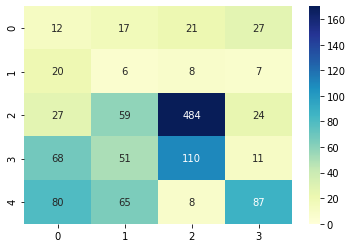

In [ ]:
# labels = labels_val[:3000]
# labels = labels_train
# ones = np.ones((len(np.reshape(k_all, (-1)))))
ones = np.ones((len(np.reshape(k_train, (-1)))))
clust_matr1 = np.zeros(som_dim[0]*som_dim[1])
for i in range(som_dim[0]*som_dim[1]):
    s1 = len(labels_train[np.where(np.reshape(k_all, (-1))==i)])# / np.sum(ones[np.where(np.reshape(k_all, (-1))==i)])
    s1 = len(labels_train[np.where(np.reshape(k_train, (-1))==i)])
    # print(i, s1)
    clust_matr1[i] = s1
clust_matr1 = np.reshape(clust_matr1, (som_dim[0],som_dim[1]))
ax = sns.heatmap(clust_matr1, cmap="YlGnBu", vmin=0,vmax=170, annot=True, fmt=".0f")
plt.show()

### Get Prototypes

k -> indica a que cluster pertenece cada ejemplo


In [ ]:
x_train = np.squeeze(data_train, axis=3)
print(x_train.shape)
print(labels_train.shape)
print(k_train.shape)
print(np.unique(k_train))
print(np.where(k_train == np.unique(k_train)[0])[0])

(1192, 72, 6)
(1192,)
(1192,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[   1  100  139  284  496  545  590  650  872  983 1014 1050]


In [ ]:
def confusion_matrix(y_train, y_clus, n_prototypes):
    n_classes = np.unique(y_train).shape[0]
    conf = np.zeros((n_classes,n_prototypes), dtype=int)
    n_instances = y_clus.shape[0]
    for k in range(n_instances):
        i = y_train[k]
        j = y_clus[k]
        conf[i][j] += 1 
    return conf

In [ ]:
conf = confusion_matrix(labels_train, k_train, som_dim[0]*som_dim[1])

In [ ]:
def matprint(mat, fmt="g"): #print confusion matrix
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T] 
    # print(col_maxes)
    for x in mat:
        # print(x)
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

In [ ]:
matprint(conf)

2   3   3  8  5  1  1  1   3   9  159  2   9   7  27  2  14  12  1  29  
5  10  12  9  8  1  2  4  16  23   19  9  42  27  38  0  41  31  1   1  
2   2   1  3  2  2  2  1   6  13  159  5   9   6  19  6  15   8  4  34  
3   2   5  7  5  2  3  1   2  14  147  8   8  11  26  3  10  14  2  23  


In [ ]:
def get_cidx_(conf_):
    cidx_ = dict()
    for j in range(conf_.shape[1]):
        cl = np.argmax(conf_[:,j])
        cidx_[j] = cl  #Clase (0,1,2,3) a la que pertece cada cluster
    return cidx_

In [ ]:
cidx = {i:get_cidx_(conf)[i] for i in np.unique(k_train)}

In [ ]:
print(cidx)

{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 2, 6: 3, 7: 1, 8: 1, 9: 1, 10: 0, 11: 1, 12: 1, 13: 1, 14: 1, 15: 2, 16: 1, 17: 1, 18: 2, 19: 2}


In [ ]:
from tslearn.barycenters import dtw_barycenter_averaging

In [ ]:
n_instances = x_train.shape[0]
n_clusters = np.unique(k_train)
# n_prototypes = len(np.unique(k_train))
prototypes = []
for i in n_clusters:
    digits = np.where(k_train == i)[0]
    cls = cidx[i]
    x_ = x_train[digits,:,:] #datos agrupados en el i-ésimo cluster 
    y_ = labels_train[digits]
    digits_ = np.where(y_ == cls)[0] #ids de datos en que coincide la clase real y la del cluster
    ba = dtw_barycenter_averaging(x_[digits_,:,:]) #obtener el prototipo
    prototypes.append(ba)
prototypes = np.array(prototypes) 

In [ ]:
print(prototypes.shape)
print(cidx)
print(np.unique(list(cidx.values())))

(20, 72, 6)
{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 2, 6: 3, 7: 1, 8: 1, 9: 1, 10: 0, 11: 1, 12: 1, 13: 1, 14: 1, 15: 2, 16: 1, 17: 1, 18: 2, 19: 2}
[0 1 2 3]


In [ ]:
for i in range(len(cidx)):
    cidx[i] = cidx.pop(np.unique(k_train)[i])

print(cidx)

{0: 0, 1: 0, 2: 3, 3: 1, 4: 1, 5: 1, 6: 3, 7: 2, 8: 1, 9: 0, 10: 1, 11: 1, 12: 0, 13: 2, 14: 0, 15: 0, 16: 0, 17: 0, 18: 3, 19: 1, 20: 0, 21: 2, 22: 2, 23: 2, 24: 1, 25: 2, 26: 0, 27: 1, 28: 0, 29: 3, 30: 3, 31: 3, 32: 0, 33: 1, 34: 0, 35: 3, 36: 1, 37: 0, 38: 0, 39: 0, 40: 2, 41: 3, 42: 0}


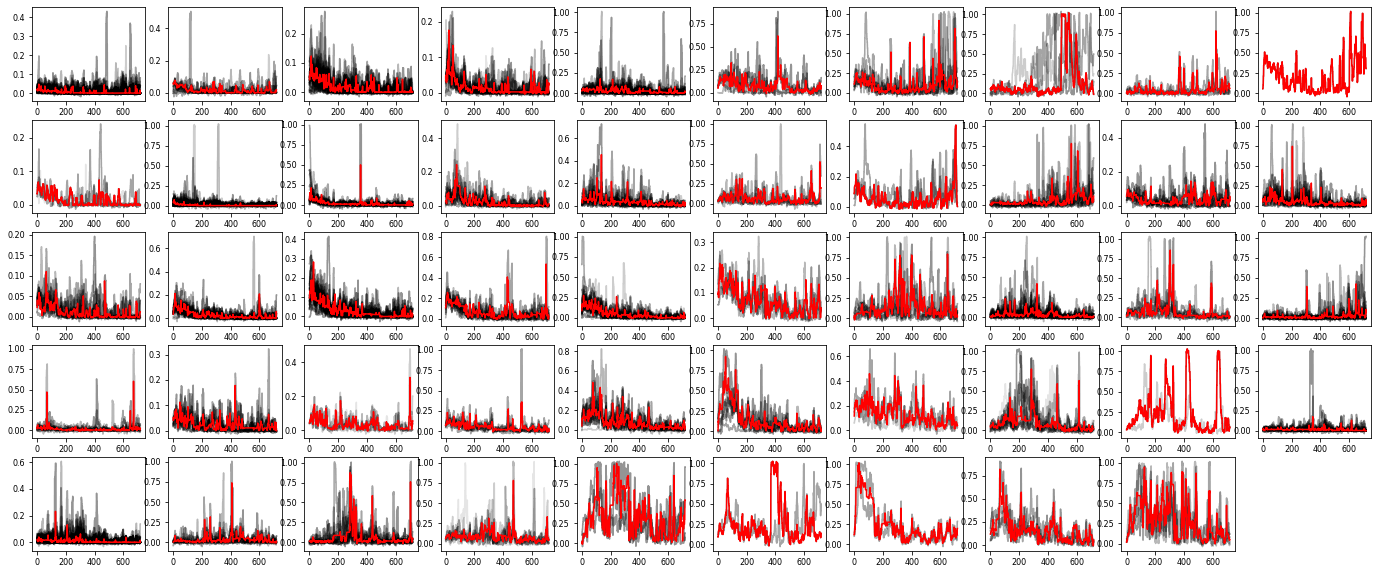

In [ ]:
prototypes = prototypes
h_clus = np.unique(k_train)
plt.rcParams["figure.figsize"] = (24,10)
plt.rcParams.update({'font.size': 8})
plt.figure()
for i in range(len(prototypes)):
        plt.subplot(5, 10, i+1)
        for xx in x_train[k_train == np.unique(k_train)[i]]:
            plt.plot(xx[:,1].ravel(), "k-", alpha=.1)
            #plt.ylim(0,1)
        plt.plot(prototypes[i][:,1].ravel(), "r-")

In [ ]:
prototypes.shape

(20, 72, 6)

In [ ]:
import pickle
# for_save = {'labels':list(cidx.values()), 'prototypes':prototypes, 'h_clus':k_train}
for_save = {'labels':cidx, 'prototypes':prototypes, 'h_clus':k_train}
with open("prototypes_som_20_minmax_6st.data", "wb") as txt_file:
    pickle.dump(for_save, txt_file)

In [ ]:
with open("prototypes_som_50_minmax_tsaug_6st.data", "rb") as txt_file:
    new_data = pickle.load(txt_file)

In [ ]:
print(new_data['labels'])
print(new_data['prototypes'].shape)
print(new_data['h_clus'])

{0: 2, 1: 1, 2: 1, 3: 3, 4: 1, 5: 1, 6: 1, 7: 1, 8: 3, 9: 3, 10: 0, 11: 0, 12: 1, 13: 0, 14: 1, 15: 2, 16: 1, 17: 3, 18: 1, 19: 1, 21: 0, 22: 0, 23: 1, 24: 1, 25: 1, 26: 1, 27: 3, 28: 2, 29: 3, 30: 3, 31: 3, 32: 1, 33: 3, 34: 1, 35: 1, 36: 0, 37: 1, 38: 1, 39: 0, 40: 2, 41: 3, 42: 3, 43: 1, 44: 1, 45: 3, 46: 0, 47: 0, 48: 1, 49: 3}
(49, 720, 6)
[41 12  0 ... 43 41  2]


# Original

In [ ]:
import functools
import numpy as np
%tensorflow_version 1.x
import tensorflow as tf
tf.version

def weight_variable(shape, name):
    """Creates a TensorFlow Variable with a given shape and name and truncated normal initialization."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial,name=name)


def bias_variable(shape, name):
    """Creates a TensorFlow Variable with a given shape and name and constant initialization."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)


def conv2d(x, shape, name, strides=[1,1,1,1]):
    """Creates a 2D convolutional layer with weight and bias variables.
    
    Args:
        x (tf.Tensor): Input tensor.
        shape (list): Shape of the weight matrix.
        name (str): Name of the layer.
        strides (list): Strides for the convolution (default: [1,1,1,1]).
    Returns:
        tf.Tensor: The convolution defined by the weight matrix and the biases with the given strides.
    """
    weight = weight_variable(shape, "{}_W".format(name))
    bias = bias_variable([shape[-1]], "{}_b".format(name))
    return tf.nn.conv2d(x, weight, strides=strides, padding='SAME', name=name) + bias


def conv2d_transposed(x, shape, outshape, name, strides=[1,1,1,1]):
    """Creates a transposed convolutional layer simimar to conv2d.
    
    Args:
        x (tf.Tensor): Input tensor.
        shape (list): Shape of the weight matrix.
        name (str): Name of the layer.
        strides (list): Strides for the convolution (default: [1,1,1,1]).
    Returns:
        tf.Tensor: The transposed convolution defined by the weight matrix and the biases with the given strides.
    """
    weight = weight_variable(shape, "{}_W".format(name))
    bias = bias_variable([shape[-2]], "{}_b".format(name))
    return tf.nn.conv2d_transpose(x, weight, output_shape=outshape, strides=strides, padding='SAME', name=name) + bias


def max_pool_2x2(x):
    """Creates a 2x2 max-pooling layer."""
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


def conv1d(x, shape, name, stride=1):
    """Creates a 1D convolutional layer with weight and bias variables.
    
    Args:
        x (tf.Tensor): Input tensor.
        shape (list): Shape of the weight matrix.
        name (str): Name of the layer.
        stride (int): Stride for the convolution (default: 1).
    Returns:
        tf.Tensor: The convolution defined by the weight matrix and the biases with the given stride.
    """
    weight = weight_variable(shape, "{}_W".format(name))
    bias = bias_variable([shape[-1]], "{}_b".format(name))
    return tf.nn.conv1d(x, weight, stride=stride, padding='SAME', name=name) + bias


def max_pool_2x1(x):
    """Creates a 2x1 max-pooling layer."""
    return tf.layers.max_pooling1d(x, pool_size=2, strides=2, padding='SAME')


def lazy_scope(function):
    """Creates a decorator for methods that makes their return values load lazily.
    
    A method with this decorator will only compute the return value once when called
    for the first time. Afterwards, the value will be cached as an object attribute.
    Inspired by: https://danijar.com/structuring-your-tensorflow-models
    
    Args:
        function (func): Function to be decorated.
        
    Returns:
        decorator: Decorator for the function.
    """
    attribute = "_cache_" + function.__name__

    @property
    @functools.wraps(function)
    def decorator(self):
        if not hasattr(self, attribute):
            with tf.variable_scope(function.__name__):
                setattr(self, attribute, function(self))
        return getattr(self, attribute)
    return decorator


class SOMVAE:
    """Class for the SOM-VAE model as described in https://arxiv.org/abs/1806.02199"""

    def __init__(self, inputs, latent_dim=64, som_dim=[8,8], learning_rate=1e-4, decay_factor=0.95, decay_steps=1000,
            input_length=28, input_channels=28, alpha=1., beta=1., gamma=1., tau=1., mnist=True):
        """Initialization method for the SOM-VAE model object.
        
        Args:
            inputs (tf.Tensor): The input tensor for the model.
            latent_dim (int): The dimensionality of the latent embeddings (default: 64).
            som_dim (list): The dimensionality of the self-organizing map (default: [8,8]).
            learning_rate (float): The learning rate for the optimization (default: 1e-4).
            decay_factor (float): The factor for the learning rate decay (default: 0.95).
            decay_steps (int): The number of optimization steps before every learning rate
                decay (default: 1000).
            input_length (int): The length of the input data points (default: 28).
            input_channels (int): The number of channels of the input data points (default: 28).
            alpha (float): The weight for the commitment loss (default: 1.).
            beta (float): The weight for the SOM loss (default: 1.).
            gamma (float): The weight for the transition probability loss (default: 1.).
            tau (float): The weight for the smoothness loss (default: 1.).
            mnist (bool): Flag that tells the model if we are training in MNIST-like data (default: True).
        """
        self.inputs = inputs
        self.latent_dim = latent_dim
        self.som_dim = som_dim
        self.learning_rate = learning_rate
        self.decay_factor = decay_factor
        self.decay_steps = decay_steps
        self.input_length = input_length
        self.input_channels = input_channels
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.tau = tau
        self.mnist = mnist
        self.batch_size
        self.embeddings
        self.transition_probabilities
        self.global_step
        self.z_e
        self.z_e_old
        self.z_dist_flat
        self.k
        self.z_q
        self.z_q_neighbors
        self.reconstruction_q
        self.reconstruction_e
        self.loss_reconstruction
        self.loss_commit
        self.loss_som
        self.loss_probabilities
        self.loss_z_prob
        self.loss
        self.optimize


    @lazy_scope
    def embeddings(self):
        """Creates variable for the SOM embeddings."""
        embeddings = tf.get_variable("embeddings", self.som_dim+[self.latent_dim],
                             initializer=tf.truncated_normal_initializer(stddev=0.05))
        tf.summary.tensor_summary("embeddings", embeddings)
        return embeddings #SOM map with shape som_dim[0], som_dim[1], latent_dim


    @lazy_scope
    def transition_probabilities(self):
        """Creates tensor for the transition probabilities."""
        with tf.variable_scope("probabilities"):
            probabilities_raw = tf.Variable(tf.zeros(self.som_dim+self.som_dim), name="probabilities_raw")
            probabilities_positive = tf.exp(probabilities_raw)
            probabilities_summed = tf.reduce_sum(probabilities_positive, axis=[-1,-2], keepdims=True)
            probabilities_normalized = probabilities_positive / probabilities_summed
            return probabilities_normalized


    @lazy_scope
    def global_step(self):
        """Creates global_step variable for the optimization."""
        global_step = tf.Variable(0, trainable=False, name="global_step")
        return global_step


    @lazy_scope
    def batch_size(self):
        """Reads the batch size from the input tensor."""
        batch_size = tf.shape(self.inputs)[0]
        return batch_size


    @lazy_scope
    def z_e(self):
        """Computes the latent encodings of the inputs."""
        if not self.mnist:
            with tf.variable_scope("encoder"):
                print('inputs ', self.inputs.shape)
                h_1 = tf.keras.layers.Dense(256, activation="relu")(self.inputs)
                h_2 = tf.keras.layers.Dense(128, activation="relu")(h_1)
                h_3 = tf.keras.layers.Flatten()(h_2)
                z_e = tf.keras.layers.Dense(self.latent_dim, activation="relu")(h_3)#(h_2)
                print('z_e', z_e)
        else:
            with tf.variable_scope("encoder"):
                h_conv1 = tf.nn.relu(conv2d(self.inputs, [4,4,1,256], "conv1"))
                h_pool1 = max_pool_2x2(h_conv1)
                h_conv2 = tf.nn.relu(conv2d(h_pool1, [4,4,256,256], "conv2"))
                h_pool2 = max_pool_2x2(h_conv2)
                flat_size = 7*7*256
                h_flat = tf.reshape(h_pool2, [-1, flat_size])
                z_e = tf.keras.layers.Dense(self.latent_dim)(h_flat)
        return z_e


    @lazy_scope
    def z_e_old(self): #no se usa
        """Aggregates the encodings of the respective previous time steps."""
        z_e_old = tf.concat([self.z_e[0:1], self.z_e[:-1]], axis=0)
        return z_e_old


    @lazy_scope
    def z_dist_flat(self):
        """Computes the distances between the encodings and the embeddings."""
        print('z_dist_flat z_e', self.z_e)
        print('z_dist_flat z_e', tf.expand_dims(tf.expand_dims(self.z_e, 1), 1))
        print('z_dist_flat embeddings', self.embeddings)
        print('z_dist_flat embeddings', tf.expand_dims(self.embeddings, 0))
        z_dist = tf.squared_difference(tf.expand_dims(tf.expand_dims(self.z_e, 1), 1), tf.expand_dims(self.embeddings, 0))
        z_dist_red = tf.reduce_sum(z_dist, axis=-1)
        z_dist_flat = tf.reshape(z_dist_red, [self.batch_size, -1])
        return z_dist_flat


    @lazy_scope
    def k(self):
        """Picks the index of the closest embedding for every encoding."""
        k = tf.argmin(self.z_dist_flat, axis=-1)
        tf.summary.histogram("clusters", k)
        return k


    @lazy_scope
    def z_q(self):
        """Aggregates the respective closest embedding for every encoding."""
        k_1 = self.k // self.som_dim[1]
        k_2 = self.k % self.som_dim[1]
        k_stacked = tf.stack([k_1, k_2], axis=1)
        z_q = tf.gather_nd(self.embeddings, k_stacked) #de los embeddings agarra los indices k_stacked
        return z_q


    @lazy_scope
    def z_q_neighbors(self):
        """Aggregates the respective neighbors in the SOM for every embedding in z_q."""
        k_1 = self.k // self.som_dim[1]
        k_2 = self.k % self.som_dim[1]
        k_stacked = tf.stack([k_1, k_2], axis=1)

        k1_not_top = tf.less(k_1, tf.constant(self.som_dim[0]-1, dtype=tf.int64))
        k1_not_bottom = tf.greater(k_1, tf.constant(0, dtype=tf.int64))
        k2_not_right = tf.less(k_2, tf.constant(self.som_dim[1]-1, dtype=tf.int64))
        k2_not_left = tf.greater(k_2, tf.constant(0, dtype=tf.int64))

        k1_up = tf.where(k1_not_top, tf.add(k_1, 1), k_1)
        k1_down = tf.where(k1_not_bottom, tf.subtract(k_1, 1), k_1)
        k2_right = tf.where(k2_not_right, tf.add(k_2, 1), k_2)
        k2_left = tf.where(k2_not_left, tf.subtract(k_2, 1), k_2)

        z_q_up = tf.where(k1_not_top, tf.gather_nd(self.embeddings, tf.stack([k1_up, k_2], axis=1)),
                          tf.zeros([self.batch_size, self.latent_dim]))
        z_q_down = tf.where(k1_not_bottom, tf.gather_nd(self.embeddings, tf.stack([k1_down, k_2], axis=1)),
                          tf.zeros([self.batch_size, self.latent_dim]))
        z_q_right = tf.where(k2_not_right, tf.gather_nd(self.embeddings, tf.stack([k_1, k2_right], axis=1)),
                          tf.zeros([self.batch_size, self.latent_dim]))
        z_q_left = tf.where(k2_not_left, tf.gather_nd(self.embeddings, tf.stack([k_1, k2_left], axis=1)),
                          tf.zeros([self.batch_size, self.latent_dim]))

        z_q_neighbors = tf.stack([self.z_q, z_q_up, z_q_down, z_q_right, z_q_left], axis=1)
        return z_q_neighbors


    @lazy_scope
    def reconstruction_q(self):
        """Reconstructs the input from the embeddings."""
        if not self.mnist:
            with tf.variable_scope("decoder", reuse=tf.AUTO_REUSE):
                # h_1 = tf.keras.layers.Dense(256, activation="relu")(self.inputs)
                # h_2 = tf.keras.layers.Dense(128, activation="relu")(h_1)
                # h_3 = tf.keras.layers.Flatten()(h_2)
                # z_e = tf.keras.layers.Dense(self.latent_dim, activation="relu")(h_3)#(h_2)

                print('reconstruction q', self.z_q)
                flat_size = self.inputs.shape[1]*self.inputs.shape[2]*self.inputs.shape[3] # self.input_channels*self.input_length*self.latent_dim
                h_4 = tf.keras.layers.Dense(flat_size, activation="relu")(self.z_q)
                h_reshaped = tf.reshape(h_4, [-1, self.inputs.shape[1],self.inputs.shape[2],self.inputs.shape[3]])
                h_4 = tf.keras.layers.Dense(128, activation="relu")(h_reshaped)
                h_5 = tf.keras.layers.Dense(256, activation="relu")(h_4)
                x_hat = tf.keras.layers.Dense(self.inputs.shape[-1], activation="sigmoid")(h_5)
                print('reconstruction q x_hat ', x_hat)
        else:
            with tf.variable_scope("decoder", reuse=tf.AUTO_REUSE):
                # h_conv1 = tf.nn.relu(conv2d(self.inputs, [4,4,1,256], "conv1"))
                # h_pool1 = max_pool_2x2(h_conv1)
                # h_conv2 = tf.nn.relu(conv2d(h_pool1, [4,4,256,256], "conv2"))
                # h_pool2 = max_pool_2x2(h_conv2)
                # flat_size = 7*7*256
                # h_flat = tf.reshape(h_pool2, [-1, flat_size])
                # z_e = tf.keras.layers.Dense(self.latent_dim)(h_flat)


                flat_size = 7*7*256
                h_flat_dec = tf.keras.layers.Dense(flat_size)(self.z_q)
                h_reshaped = tf.reshape(h_flat_dec, [-1, 7, 7, 256])
                h_unpool1 = tf.keras.layers.UpSampling2D((2,2))(h_reshaped)
                h_deconv1 = tf.nn.relu(conv2d(h_unpool1, [4,4,256,256], "deconv1"))
                h_unpool2 = tf.keras.layers.UpSampling2D((2,2))(h_deconv1)
                h_deconv2 = tf.nn.sigmoid(conv2d(h_unpool2, [4,4,256,1], "deconv2"))
                x_hat = h_deconv2
        return x_hat


    @lazy_scope
    def reconstruction_e(self):
        """Reconstructs the input from the encodings."""
        if not self.mnist:
            with tf.variable_scope("decoder", reuse=tf.AUTO_REUSE):
                # h_3 = tf.keras.layers.Dense(128, activation="relu")(self.z_e)
                # h_4 = tf.keras.layers.Dense(256, activation="relu")(h_3)
                # x_hat = tf.keras.layers.Dense(self.input_channels, activation="sigmoid")(h_4)

                print('reconstruction e', self.z_e)
                flat_size = self.inputs.shape[1]*self.inputs.shape[2]*self.inputs.shape[3] #self.input_channels*self.input_length*self.latent_dim
                h_4 = tf.keras.layers.Dense(flat_size, activation="relu")(self.z_e)
                h_reshaped = tf.reshape(h_4, [-1, self.inputs.shape[1],self.inputs.shape[2],self.inputs.shape[3]])
                h_4 = tf.keras.layers.Dense(128, activation="relu")(h_reshaped)
                h_5 = tf.keras.layers.Dense(256, activation="relu")(h_4)
                x_hat = tf.keras.layers.Dense(self.inputs.shape[-1], activation="sigmoid")(h_5)
                print('reconstruction e x_hat ', x_hat)
        else:
            with tf.variable_scope("decoder", reuse=tf.AUTO_REUSE):
                flat_size = 7*7*256
                h_flat_dec = tf.keras.layers.Dense(flat_size)(self.z_e)
                h_reshaped = tf.reshape(h_flat_dec, [-1, 7, 7, 256])
                h_unpool1 = tf.keras.layers.UpSampling2D((2,2))(h_reshaped)
                h_deconv1 = tf.nn.relu(conv2d(h_unpool1, [4,4,256,256], "deconv1"))
                h_unpool2 = tf.keras.layers.UpSampling2D((2,2))(h_deconv1)
                h_deconv2 = tf.nn.sigmoid(conv2d(h_unpool2, [4,4,256,1], "deconv2"))
                x_hat = h_deconv2
        return x_hat


    @lazy_scope
    def loss_reconstruction(self):
        """Computes the combined reconstruction loss for both reconstructions."""
        loss_rec_mse_zq = tf.losses.mean_squared_error(self.inputs, self.reconstruction_q)
        loss_rec_mse_ze = tf.losses.mean_squared_error(self.inputs, self.reconstruction_e)
        loss_rec_mse = loss_rec_mse_zq + loss_rec_mse_ze
        tf.summary.scalar("loss_reconstruction", loss_rec_mse)
        return loss_rec_mse


    @lazy_scope
    def loss_commit(self):
        """Computes the commitment loss."""
        loss_commit = tf.reduce_mean(tf.squared_difference(self.z_e, self.z_q))
        tf.summary.scalar("loss_commit", loss_commit)
        return loss_commit


    @lazy_scope
    def loss_som(self):
        """Computes the SOM loss."""
        loss_som = tf.reduce_mean(tf.squared_difference(tf.expand_dims(tf.stop_gradient(self.z_e), axis=1), self.z_q_neighbors))
        tf.summary.scalar("loss_som", loss_som)
        return loss_som


    @lazy_scope
    def loss_probabilities(self):
        """Computes the negative log likelihood loss for the transition probabilities."""
        k_1 = self.k // self.som_dim[1]
        k_2 = self.k % self.som_dim[1]
        k_1_old = tf.concat([k_1[0:1], k_1[:-1]], axis=0)
        k_2_old = tf.concat([k_2[0:1], k_2[:-1]], axis=0)
        k_stacked = tf.stack([k_1_old, k_2_old, k_1, k_2], axis=1)
        transitions_all = tf.gather_nd(self.transition_probabilities, k_stacked)
        loss_probabilities = -self.gamma * tf.reduce_mean(tf.log(transitions_all))
        return loss_probabilities


    @lazy_scope
    def loss_z_prob(self):
        """Computes the smoothness loss for the transitions given their probabilities."""
        k_1 = self.k // self.som_dim[1]
        k_2 = self.k % self.som_dim[1]
        k_1_old = tf.concat([k_1[0:1], k_1[:-1]], axis=0)
        k_2_old = tf.concat([k_2[0:1], k_2[:-1]], axis=0)
        k_stacked_old = tf.stack([k_1_old, k_2_old], axis=1)
        out_probabilities_old = tf.gather_nd(self.transition_probabilities, k_stacked_old)
        out_probabilities_flat = tf.reshape(out_probabilities_old, [self.batch_size, -1])
        weighted_z_dist_prob = tf.multiply(self.z_dist_flat, out_probabilities_flat)
        loss_z_prob = tf.reduce_mean(weighted_z_dist_prob)
        return loss_z_prob


    @lazy_scope
    def loss(self):
        """Aggregates the loss terms into the total loss."""
        loss = (self.loss_reconstruction + self.alpha*self.loss_commit + self.beta*self.loss_som
                + self.gamma*self.loss_probabilities + self.tau*self.loss_z_prob)
        tf.summary.scalar("loss", loss)
        return loss


    @lazy_scope
    def optimize(self):
        """Optimizes the model's loss using Adam with exponential learning rate decay."""
        lr_decay = tf.train.exponential_decay(self.learning_rate, self.global_step, self.decay_steps, self.decay_factor, staircase=True)
        optimizer = tf.train.AdamOptimizer(lr_decay)
        train_step = optimizer.minimize(self.loss, global_step=self.global_step)
        train_step_prob = optimizer.minimize(self.loss_probabilities, global_step=self.global_step)
        return train_step, train_step_prob


In [ ]:
import os
import uuid
import shutil
from glob import glob
from datetime import date

import numpy as np
import tensorflow as tf
# from tensorflow.examples.tutorials.mnist import input_data
import pandas as pd
from sklearn.metrics import mean_squared_error
from tqdm import tqdm, trange
# !pip install sacred 
import sacred
from sacred.stflow import LogFileWriter

# from labwatch.assistant import LabAssistant
# from labwatch.optimizers.random_search import RandomSearch
# from labwatch.optimizers.smac_wrapper import SMAC
# from labwatch.optimizers.bayesian_optimization import BayesianOptimization
# from labwatch import hyperparameters as hyper

# from somvae_model import SOMVAE
from utils import *

ex = sacred.Experiment("time_serie", interactive=True)
ex.observers.append(sacred.observers.FileStorageObserver.create("./sacred_runs"))
ex.captured_out_filter = sacred.utils.apply_backspaces_and_linefeeds

# ex.observers.append(sacred.observers.MongoObserver.create(db_name="somvae_hyperopt"))

# assistant = LabAssistant(ex, "somvae_hyperopt", optimizer=SMAC, url="localhost:{}".format(db_port))


@ex.config
def ex_config():
    """Sacred configuration for the experiment.
    
    Params:
        num_epochs (int): Number of training epochs.
        patience (int): Patience for the early stopping.
        batch_size (int): Batch size for the training.
        latent_dim (int): Dimensionality of the SOM-VAE's latent space.
        som_dim (list): Dimensionality of the self-organizing map.
        learning_rate (float): Learning rate for the optimization.
        alpha (float): Weight for the commitment loss.
        beta (float): Weight for the SOM loss.
        gamma (float): Weight for the transition probability loss.
        tau (float): Weight for the smoothness loss.
        decay_factor (float): Factor for the learning rate decay.
        name (string): Name of the experiment.
        ex_name (string): Unique name of this particular run.
        logdir (path): Directory for the experiment logs.
        modelpath (path): Path for the model checkpoints.
        interactive (bool): Indicator if there should be an interactive progress bar for the training.
        data_set (string): Data set for the training.
        save_model (bool): Indicator if the model checkpoints should be kept after training and evaluation.
        time_series (bool): Indicator if the model should be trained on linearly interpolated
            MNIST time series.
        mnist (bool): Indicator if the model is trained on MNIST-like data.
    """
    num_epochs = 20
    patience = 100
    batch_size = 32
    latent_dim = 64
    som_dim = [8,8]
    learning_rate = 0.0005
    alpha = 1.0
    beta = 0.9
    gamma = 1.8
    tau = 1.4
    decay_factor = 0.9
    name = ex.get_experiment_info()["name"]
    ex_name = "{}_{}_{}-{}_{}_{}".format(name, latent_dim, som_dim[0], som_dim[1], str(date.today()), uuid.uuid4().hex[:5])
    logdir = "./logs/{}".format(ex_name)
    modelpath = "./models/{}/{}.ckpt".format(ex_name, ex_name)
    interactive = True
    data_set = "MNIST_data"
    save_model = False
    time_series = True
    mnist = False # True


# @assistant.search_space
# def search_space():
#     num_epochs = 20
#     patience = 20
#     batch_size = 32
#     latent_dim = hyper.UniformInt(lower=64, upper=256, log_scale=True)
#     som_dim = [8,8]
#     learning_rate = hyper.UniformFloat(lower=0.0001, upper=0.01, log_scale=True)
#     alpha = hyper.UniformFloat(lower=0., upper=2.)
#     beta = hyper.UniformFloat(lower=0., upper=2.)
#     gamma = hyper.UniformFloat(lower=0., upper=2.)
#     tau = hyper.UniformFloat(lower=0., upper=2.)
#     decay_factor = hyper.UniformFloat(lower=0.8, upper=1.)
#     interactive = False

# mnist = input_data.read_data_sets(f"../data/{ex_config()['data_set']}")
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# data_train = np.reshape(x_train, [-1,28,28,1])
# labels_train = y_train
# data_val = data_train[45000:]
# labels_val = labels_train[45000:]
# data_train = data_train[:45000]
# labels_train = labels_train[:45000]


@ex.capture
def get_data_generator(time_series):
    """Creates a data generator for the training.
    
    Args:
        time_series (bool): Indicates whether or not we want interpolated MNIST time series or just
            normal MNIST batches.
    
    Returns:
        generator: Data generator for the batches."""

    def batch_generator(mode="train", batch_size=100):
        """Generator for the data batches.
        
        Args:
            mode (str): Mode in ['train', 'val'] that decides which data set the generator
                samples from (default: 'train').
            batch_size (int): The size of the batches (default: 100).
            
        Yields:
            np.array: Data batch.
        """
        assert mode in ["train", "val"], "The mode should be in {train, val}."
        if mode=="train":
            images = data_train.copy()
            labels = labels_train.copy()
        elif mode=="val":
            images = data_val.copy()
            labels = labels_val.copy()
        
        while True:
            indices = np.random.permutation(np.arange(len(images)))
            images = images[indices]
            labels = labels[indices]

            if time_series:
                for i, image in enumerate(images):
                    start_image = image
                    # print('labels: ', labels[i])
                    # print('where: ', np.where(labels == (labels[i]) % 10))
                    # print('choice: ', np.random.choice(np.where(labels == (labels[i]) % 10)[0]))
                    end_image = images[np.random.choice(np.where(labels == (labels[i]) % 10)[0])]
                    interpolation = interpolate_arrays(start_image, end_image, batch_size)
                    yield interpolation + np.random.normal(scale=0.01, size=interpolation.shape)
            else:
                for i in range(len(images)//batch_size):
                    yield images[i*batch_size:(i+1)*batch_size]

    return batch_generator


@ex.capture
def train_model(model, x, lr_val, num_epochs, patience, batch_size, logdir,
        modelpath, learning_rate, interactive, generator):
    """Trains the SOM-VAE model.
    
    Args:
        model (SOM-VAE): SOM-VAE model to train.
        x (tf.Tensor): Input tensor or placeholder.
        lr_val (tf.Tensor): Placeholder for the learning rate value.
        num_epochs (int): Number of epochs to train.
        patience (int): Patience parameter for the early stopping.
        batch_size (int): Batch size for the training generator.
        logdir (path): Directory for saving the logs.
        modelpath (path): Path for saving the model checkpoints.
        learning_rate (float): Learning rate for the optimization.
        interactive (bool): Indicator if we want to have an interactive
            progress bar for training.
        generator (generator): Generator for the data batches.
    """
    train_gen = generator("train", batch_size)
    val_gen = generator("val", batch_size)

    num_batches = len(data_train)//batch_size

    saver = tf.train.Saver(keep_checkpoint_every_n_hours=2.)
    summaries = tf.summary.merge_all()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        patience_count = 0
        test_losses = []
        with LogFileWriter(ex):
            train_writer = tf.summary.FileWriter(logdir+"/train", sess.graph)
            test_writer = tf.summary.FileWriter(logdir+"/test", sess.graph)
        print("Training...")
        train_step_SOMVAE, train_step_prob = model.optimize
        try:
            if interactive:
                pbar = tqdm(total=num_epochs*(num_batches)) 
            for epoch in range(num_epochs):
                batch_val = next(val_gen)
                test_loss, summary = sess.run([model.loss, summaries], feed_dict={x: batch_val})
                test_losses.append(test_loss)
                test_writer.add_summary(summary, tf.train.global_step(sess, model.global_step))
                if test_losses[-1] == min(test_losses):
                    saver.save(sess, modelpath, global_step=epoch)
                    patience_count = 0
                else:
                    patience_count += 1
                if patience_count >= patience:
                    break
                for i in range(num_batches):
                    batch_data = next(train_gen)
                    if i%100 == 0:
                        train_loss, summary = sess.run([model.loss, summaries], feed_dict={x: batch_data})
                        train_writer.add_summary(summary, tf.train.global_step(sess, model.global_step))
                    train_step_SOMVAE.run(feed_dict={x: batch_data, lr_val:learning_rate})
                    train_step_prob.run(feed_dict={x: batch_data, lr_val:learning_rate*100})
                    if interactive:
                        pbar.set_postfix(epoch=epoch, train_loss=train_loss, test_loss=test_loss, refresh=False)
                        pbar.update(1)

        except KeyboardInterrupt:
            pass
        finally:
            saver.save(sess, modelpath)
            if interactive:
                pbar.close()



@ex.capture
def evaluate_model(model, x, modelpath, batch_size):
    """Evaluates the performance of the trained model in terms of normalized
    mutual information, purity and mean squared error.
    
    Args:
        model (SOM-VAE): Trained SOM-VAE model to evaluate.
        x (tf.Tensor): Input tensor or placeholder.
        modelpath (path): Path from which to restore the model.
        batch_size (int): Batch size for the evaluation.
        
    Returns:
        dict: Dictionary of evaluation results (NMI, Purity, MSE).
    """
    saver = tf.train.Saver(keep_checkpoint_every_n_hours=2.)

    num_batches = len(data_val)//batch_size

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, modelpath)

        test_k_all = []
        test_rec_all = []
        test_mse_all = []
        print("Evaluation...")
        for i in range(num_batches):
            batch_data = data_val[i*batch_size:(i+1)*batch_size]
            test_k_all.extend(sess.run(model.k, feed_dict={x: batch_data}))
            test_rec = sess.run(model.reconstruction_q, feed_dict={x: batch_data})
            test_rec_all.extend(test_rec)
            test_mse_all.append(mean_squared_error(test_rec.flatten(), batch_data.flatten()))

        test_nmi = compute_NMI(test_k_all, labels_val[:len(test_k_all)])
        test_purity = compute_purity(test_k_all, labels_val[:len(test_k_all)])
        test_mse = np.mean(test_mse_all)

    results = {}
    results["NMI"] = test_nmi
    results["Purity"] = test_purity
    results["MSE"] = test_mse
#    results["optimization_target"] = 1 - test_nmi

    return results
 

@ex.main
def main(latent_dim, som_dim, learning_rate, decay_factor, alpha, beta, gamma, tau, modelpath, save_model, mnist):
    """Main method to build a model, train it and evaluate it.
    
    Args:
        latent_dim (int): Dimensionality of the SOM-VAE's latent space.
        som_dim (list): Dimensionality of the SOM.
        learning_rate (float): Learning rate for the training.
        decay_factor (float): Factor for the learning rate decay.
        alpha (float): Weight for the commitment loss.
        beta (float): Weight for the SOM loss.
        gamma (float): Weight for the transition probability loss.
        tau (float): Weight for the smoothness loss.
        modelpath (path): Path for the model checkpoints.
        save_model (bool): Indicates if the model should be saved after training and evaluation.
        
    Returns:
        dict: Results of the evaluation (NMI, Purity, MSE).
    """
    # Dimensions for MNIST-like data
    # input_length = 28
    # input_channels = 28 #n_features
    # x = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
 
    input_length = 720
    input_channels = 5  #n_features
    x = tf.placeholder(tf.float32, shape=[None, 720, 5, 1])

    data_generator = get_data_generator()

    lr_val = tf.placeholder_with_default(learning_rate, [])

    model = SOMVAE(inputs=x, latent_dim=latent_dim, som_dim=som_dim, learning_rate=lr_val, decay_factor=decay_factor,
            input_length=input_length, input_channels=input_channels, alpha=alpha, beta=beta, gamma=gamma,
            tau=tau, mnist=mnist)

    train_model(model, x, lr_val, generator=data_generator)

    result = evaluate_model(model, x)

    if not save_model:
        shutil.rmtree(os.path.dirname(modelpath))

    return result

In [ ]:
data_train.shape

(654, 720, 5, 1)

In [ ]:
labels_train.shape

(654,)

In [ ]:
tf.reset_default_graph()
r = ex.run()

INFO - time_serie - Running command 'main'
INFO - time_serie - Started run with ID "3"


inputs  (?, 720, 5, 1)
z_e Tensor("z_e/encoder/dense_2/Relu:0", shape=(?, 64), dtype=float32)
z_dist_flat z_e Tensor("z_e/encoder/dense_2/Relu:0", shape=(?, 64), dtype=float32)
z_dist_flat z_e Tensor("z_dist_flat/ExpandDims_1:0", shape=(?, 1, 1, 64), dtype=float32)
z_dist_flat embeddings <tf.Variable 'embeddings/embeddings:0' shape=(8, 8, 64) dtype=float32_ref>
z_dist_flat embeddings Tensor("z_dist_flat/ExpandDims_2:0", shape=(1, 8, 8, 64), dtype=float32)
reconstruction q Tensor("z_q/GatherNd:0", shape=(?, 64), dtype=float32)
reconstruction q x_hat  Tensor("reconstruction_q/decoder/dense_6/Sigmoid:0", shape=(?, 720, 5, 1), dtype=float32)
reconstruction e Tensor("z_e/encoder/dense_2/Relu:0", shape=(?, 64), dtype=float32)
reconstruction e x_hat  Tensor("reconstruction_e/decoder/dense_10/Sigmoid:0", shape=(?, 720, 5, 1), dtype=float32)


  0%|          | 0/400 [00:00<?, ?it/s]

Training...


 55%|█████▌    | 220/400 [00:28<00:17, 10.29it/s, epoch=10, test_loss=3.41, train_loss=3.41]

Instructions for updating:
Use standard file APIs to delete files with this prefix.


WARNING - tensorflow - From /tensorflow-1.15.2/python3.6/tensorflow_core/python/training/saver.py:963: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.
100%|██████████| 400/400 [01:22<00:00,  4.87it/s, epoch=19, test_loss=0.0686, train_loss=0.0595]


INFO:tensorflow:Restoring parameters from ./models/time_serie_64_8-8_2020-09-25_ce79a/time_serie_64_8-8_2020-09-25_ce79a.ckpt


INFO - tensorflow - Restoring parameters from ./models/time_serie_64_8-8_2020-09-25_ce79a/time_serie_64_8-8_2020-09-25_ce79a.ckpt


Evaluation...


INFO - time_serie - Result: {'NMI': 0.0, 'Purity': 0.25625, 'MSE': 0.01220927305029034}
INFO - time_serie - Completed after 0:01:30


In [ ]:
r.result

{'MSE': 0.012611609235261343, 'NMI': 0.0, 'Purity': 0.25625}

In [ ]:
tf.reset_default_graph()
r = ex.run()

INFO - time_serie - Running command 'main'
INFO - time_serie - Started run with ID "1"


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


WARNING - tensorflow - From /tensorflow-1.15.2/python3.6/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


z_e Tensor("z_e/encoder/dense_2/Relu:0", shape=(?, 720, 5, 64), dtype=float32)
z_dist_flat Tensor("z_e/encoder/dense_2/Relu:0", shape=(?, 720, 5, 64), dtype=float32)


ERROR - time_serie - Failed after 0:00:00!


ValueError: ignored